# 加载模型

In [6]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import importlib
# def load_all_as_globals(module_name):
#     # 动态导入模块
#     mod = importlib.import_module(module_name)

#     # 获取模块中的所有属性名称
#     module_items = dir(mod)

#     # 遍历模块的所有属性
#     for item_name in module_items:
#         # 获取属性
#         item = getattr(mod, item_name)
#         globals()[item_name] = item
# load_all_as_globals("model-src.FDDWNet")
# model = torch.load('models/FDDWNet2.pth', weights_only=False)

# 加载数据

In [7]:
import pandas as pd
trainmeta = pd.read_csv('stats/train-meta.csv', dtype=object)
testmeta = pd.read_csv('stats/test-meta.csv', dtype=object)

# 对 model 进行可视化

### 彩图制作器

In [8]:
import numpy as np
import matplotlib.patches as mpatches
color_map = {
    0: [0, 0, 0],      # Background (黑色)
    1: [255, 165, 0],     # Inclusions (浅橙色)
    2: [30, 144, 255],    # Patches (天蓝色)
    3: [50, 205, 50],     # Scratches (亮绿色)
}
legend_patches = [
    mpatches.Patch(color=np.array(color_map[0])/255, label='Background(0)'),
    mpatches.Patch(color=np.array(color_map[1])/255, label='Inclusions(1)'),
    mpatches.Patch(color=np.array(color_map[2])/255, label='Patches(2)'),
    mpatches.Patch(color=np.array(color_map[3])/255, label='Scratches(3)'),
]
def to_rgb_im(mask):
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, color in color_map.items():
        rgb_image[mask == class_idx] = color
    return rgb_image

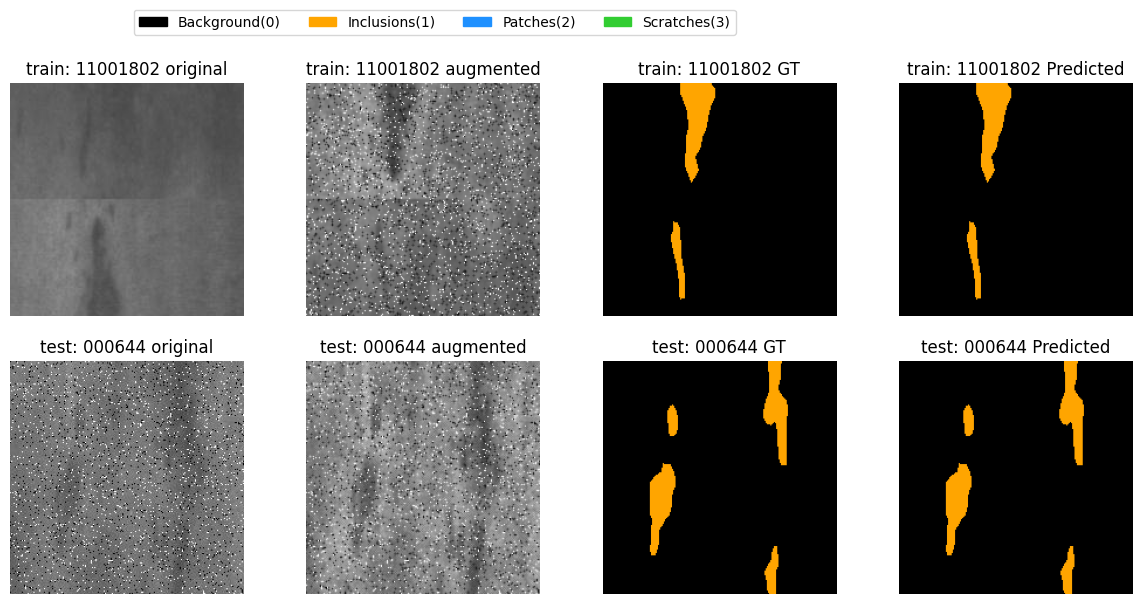

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
import numpy as np
import utils.data_augmentation as data_augmentation 

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 200)),
])


def plot_result(imid:str, train:bool, axes, if_run:bool=False):
    """
        总共绘制3张图, 第一张是原图, 第二张是预测的掩码图, 第三张是GT
        args:
            imid: 希望可视化的图片的id
            train: True: 可视化训练集图片  False: 可视化测试集图片
    """
    src = "data/images/training/" if train else "data/images/testB3/"
    imdata = Image.open(src + imid + '.jpg')
    src = "data/annotations/training/" if train else "data/annotations/testB3/"
    mask = cv2.imread(src + imid + '.png', cv2.IMREAD_GRAYSCALE)
    if train:
        mask = Image.fromarray(mask)
        aug_imdata, mask = data_augmentation.data_augmentation(imdata, mask)
        mask = np.array(mask)
    else:
        aug_imdata = data_augmentation.data_augmentation_test(imdata)

    if if_run:
        inputs = transforms(aug_imdata).cuda().unsqueeze(0)
        model = torch.load('models/FDDWNet2.pth', weights_only=False)
        with torch.no_grad():
            model.eval()
            pred = model(inputs)
            pred = torch.argmax(pred, dim=1).cpu()[0]
    else:
        pred = mask

    # 颜色转换
    mask, pred = to_rgb_im(mask), to_rgb_im(pred)

    axes[0].imshow(imdata)
    axes[0].axis('off')
    axes[0].set_title(('train' if train else 'test') + f': {imid} original')
    axes[1].imshow(aug_imdata) 
    axes[1].axis('off') 
    axes[1].set_title(('train' if train else 'test') + f': {imid} augmented')
    axes[2].imshow(mask)
    axes[2].axis('off')
    axes[2].set_title(('train' if train else 'test') + f': {imid} GT') 
    axes[3].imshow(pred)
    axes[3].axis('off')
    axes[3].set_title(('train' if train else 'test') + f': {imid} Predicted') 
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(0.65, 1.05), ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])


plot_result( np.random.choice(trainmeta['id']), True, axes[0])
plot_result( np.random.choice(testmeta['id']), False, axes[1])

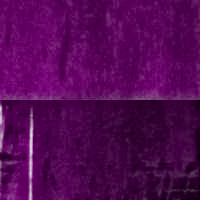

In [80]:
import numpy as np
from PIL import Image
import cv2 as cv

def build_laplacian_pyramid(channel, levels):
    # 构建高斯金字塔
    gaussian_pyramid = [channel]
    for i in range(levels):
        channel = cv2.pyrDown(channel)
        gaussian_pyramid.append(channel)

    # 构建拉普拉斯金字塔
    laplacian_pyramid = []
    for i in range(levels, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=(gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)

    return laplacian_pyramid

def enhance_laplacian_pyramid(laplacian_pyramid, alpha):
    # 增强拉普拉斯金字塔的每一层
    enhanced_pyramid = [lap * alpha for lap in laplacian_pyramid]
    return enhanced_pyramid

def reconstruct_from_laplacian_pyramid(laplacian_pyramid, original_shape):
    # 从增强后的拉普拉斯金字塔重建图像
    channel = laplacian_pyramid[0]
    for i in range(1, len(laplacian_pyramid)):
        channel = cv2.pyrUp(channel, dstsize=(laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]))
        channel = cv2.add(channel, laplacian_pyramid[i])
    # Resize to the original shape to match the other channels
    channel = cv2.resize(channel, (original_shape[1], original_shape[0]))
    return channel

def laplacian_pyramid_enhance_opencv(img, alpha=1.5, num_levels=5, channel_index=0):
    # 读取图像
    img = np.array(img)
    img = img.astype(np.float32)  # 转换为浮点数格式以增强对比度

    # 将图像分为 B, G, R 三个通道，并转换为可修改的列表
    channels = list(cv2.split(img))

    # 对指定通道应用拉普拉斯金字塔增强
    original_shape = channels[channel_index].shape
    laplacian_pyr = build_laplacian_pyramid(channels[channel_index], num_levels)
    enhanced_pyr = enhance_laplacian_pyramid(laplacian_pyr, alpha)
    enhanced_channel = reconstruct_from_laplacian_pyramid(enhanced_pyr, original_shape)
    
    # 将增强后的通道值限制在 0-255 之间，并转换为 uint8 格式
    enhanced_channel = np.clip(enhanced_channel, 0, 255).astype(np.uint8)
    channels[channel_index] = enhanced_channel  # 替换指定通道
    for i in range(len(channels)):
        channels[i] = cv2.resize(channels[i], (original_shape[1], original_shape[0]))
        channels[i] = channels[i].astype(np.uint8)
    # 合并通道
    enhanced_img = cv2.merge(channels)

    return Image.fromarray(enhanced_img.astype(np.uint8))

def CLAHE(img, clipLimit=2.0, tileGridSize=(8,8)):
    r_img = np.array(img)
    r_img = cv2.cvtColor(r_img, cv2.COLOR_RGB2LAB)
    r_img_l = r_img[:, :, 0] # Convert to range [0,1]
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    r_img_l = clahe.apply(r_img_l)
    r_img[:, :, 0] = r_img_l
    r_img = cv2.cvtColor(r_img, cv2.COLOR_LAB2RGB)
    return Image.fromarray(r_img)

# 示例使用
image_path = "data/images/training/11001802.jpg"
image = Image.open(image_path)
image = CLAHE(image)
image = laplacian_pyramid_enhance_opencv(image, alpha=2, num_levels=3, channel_index=1)
image

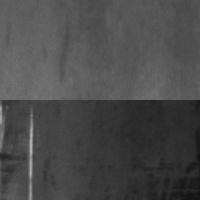

In [15]:
Image.open("data/images/training/11001802.jpg")

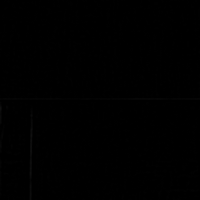

In [62]:
img = cv2.imread("data/images/training/11001802.jpg")
blurred1 = cv2.GaussianBlur(img, (5, 5), 1)
blurred2 = cv2.GaussianBlur(img, (5, 5), 2)
dog = cv2.subtract(blurred1, blurred2)
Image.fromarray(dog)

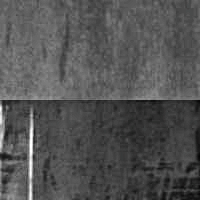

In [73]:
def USM(image, gamma=1.5):
    img = np.array(image)
    blurred = cv2.GaussianBlur(img, (9, 9), 10)
    return Image.fromarray(cv2.addWeighted(img, 1.5, blurred, -0.5, 0))

img = Image.open("data/images/training/11001802.jpg")
img = CLAHE(img)
img = USM(img, gamma=10)
img

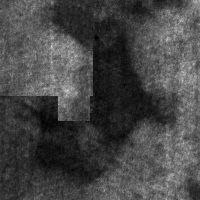

In [13]:
import cv2
import numpy as np
import random
from PIL import Image

# 读取背景图像和小图像

def overlay(img_name):
    background = cv2.imread(f'data/images/training_ori/{img_name}.jpg', cv2.IMREAD_GRAYSCALE)
    random_img = '1000538'
    overlay = cv2.imread(f'data/images/training_ori/{random_img}.jpg', cv2.IMREAD_GRAYSCALE)

    # 调整小图像的大小，若需要可以指定更小尺寸
    overlay_p1 = 0, 0
    overlay_p1 = overlay_p1[0], overlay_p1[1], overlay_p1[0] + random.randint(80, 100), overlay_p1[1] + random.randint(80, 100)
    overlay_p2 = random.randint(30, 80), random.randint(30, 80)
    overlay_p2 = overlay_p2[0], overlay_p2[1], overlay_p2[0] + random.randint(20, 100), overlay_p2[1] + random.randint(20, 100)
    positions = [overlay_p1, overlay_p2]

    # 创建一个彩色版本的背景用于合并显示
    background_color = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)

    # 不规则拼接：循环每个位置，将未缩放的小图像叠加到背景图上
    for pos in positions:
        start_x, start_y, end_x, end_y = pos

        # 计算叠加区域的边界，确保 overlay 不超出背景图像的边界

        # 对 overlay 进行裁剪以匹配 ROI 的尺寸
        overlay_cropped = overlay[start_y:end_y, start_x:end_x]
        overlay_color = cv2.cvtColor(overlay_cropped, cv2.COLOR_GRAY2BGR)

        # 提取背景中的 ROI
        roi = background_color[start_y:end_y, start_x:end_x]

        # 创建遮罩，将非零区域的值设为 255
        mask = np.ones_like(overlay_cropped, dtype=np.uint8) * 255

        # 使用遮罩将 overlay 不规则地叠加到背景图上
        np.copyto(roi, overlay_color, where=(mask[..., None] == 255))
    background_color = Image.fromarray(cv2.cvtColor(background_color, cv2.COLOR_BGR2RGB))
    return background_color

overlay('1000533')
